In [ ]:
import cv2
import torchvision.models.segmentation
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch
import os
import numpy as np
import torch.utils.data
import albumentations as A

In [46]:
from torch.utils.data import Dataset
from PIL import Image
import scipy.io as sio
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from engine import train_one_epoch, evaluate
import utils
from torchvision.transforms.functional import to_tensor,to_pil_image
from torch.utils.data import DataLoader
import matplotlib.pylab as plt

Input training image folder

In [51]:
TRAIN_IMG_DIR = "dataset/CoNSeP/Train/Images"
TRAIN_LABEL_DIR = "dataset/CoNSeP/Train/Labels"
TRAIN_MASK_DIR = "dataset/CoNSeP/Train/Overlay"

**Visualization of image alongwith mask**

In [13]:
mask= sio.loadmat("dataset/CoNSeP/Train/Labels/train_10")
img= Image.open("dataset/CoNSeP/Train/Images/train_10.png").convert('RGB')
mask=mask['inst_map']
overlay=Image.open("dataset/CoNSeP/Train/Overlay/train_10.png")

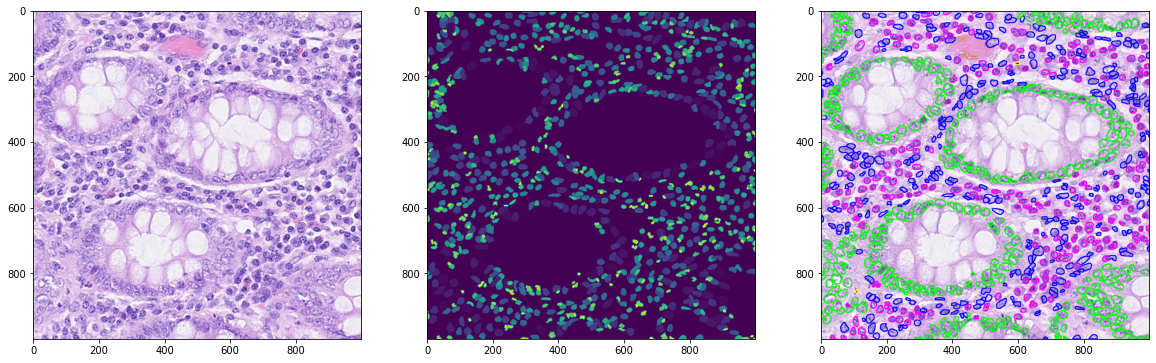

In [14]:
plt.figure(figsize=(20,20))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.subplot(1, 3, 2)
plt.imshow(mask)
plt.subplot(1, 3, 3)
plt.imshow(overlay)

**Custom Dataloader**

In [ ]:
class Our_Dataset(Dataset):
    def __init__(self, image_dir,label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir= label_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.labels=os.listdir(label_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        label_path= os.path.join(self.label_dir, self.labels[index])
        img = Image.open(img_path).convert('RGB')
        label= sio.loadmat(label_path)
        mask = label["inst_map"]
        label=label['inst_type']
        y=torch.from_numpy(label)
        label = torch.squeeze(y)
        
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        img= to_tensor(img)
        mask= torch.from_numpy(mask).type(torch.long)
        label = torch.as_tensor(label, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["masks"] = mask


        return img,target

**Data Augmentation**

In [101]:
train_transform = A.Compose(
        [
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
        ],
    )

In [103]:
train_ds=Our_Dataset(image_dir=TRAIN_IMG_DIR,label_dir=TRAIN_LABEL_DIR,transform=train_transform)
train_dl = DataLoader(train_ds, batch_size=2,num_workers=2, shuffle=True,collate_fn=utils.collate_fn)

**Model Mask RCNN**

In [104]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype

In [105]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [119]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(num_classes=7)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [120]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
epoch=5

**Training**

In [121]:
train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=2)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


IndexError: ignored

**Model with transfer learning**

In [129]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [130]:
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [138]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# Construct a learning rate scheduler
# Learning rate scheduler decreases by 10x every 5 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=5,
                                            gamma=0.1)

In [137]:
num_classes = 7
model = build_model(num_classes)

**Training**

In [139]:
train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=2)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


IndexError: ignored